In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# matplotlib style
style_name = 'bmh' #bmh
mpl.style.use(style_name)
style = plt.style.library[style_name]
style_colors = [ c['color'] for c in style['axes.prop_cycle'] ]

# matplotlib 한글출력
# plt.rcParams['font.family'] = 'NanumBarunGothic'
# mpl.rc('font', family='NanumBarunGothic')
# plt.rcParams['axes.unicode_minus'] = False

np.set_printoptions(precision=4, linewidth =150)

##########################################################
# for sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

##########################################################
# for plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from IPython.core.display import display, HTML

init_notebook_mode(connected=True)

# https://github.com/plotly/plotly.py/issues/515
# The polling here is to ensure that plotly.js has already been loaded before
# setting display alignment in order to avoid a race condition.
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))

x_train:(10,)
t_train:(10,)


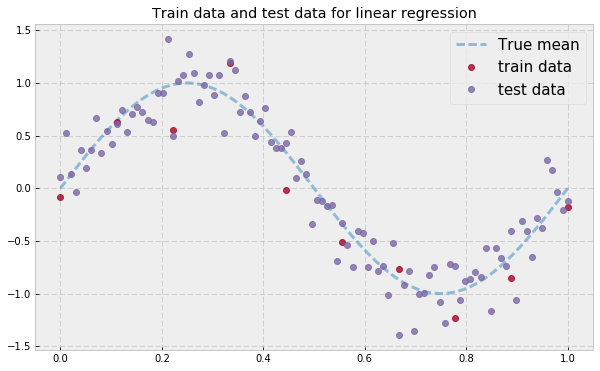

In [2]:
######################################################
# 회귀에 사용할 데이터를 준비
# 학습데이터와 테스트 데이트를 모두 준비
######################################################

plt.rcParams["figure.figsize"] = (10,6)

# 시드를 심어 항상 같은 결과가 나오게 한다.
np.random.seed(2)

# x범위는 0~1까지
x = np.linspace(0, 1, 100)
# 데이터가 생성되는 기준이 되는 함수
t = np.sin(2*np.pi*x)

N = 10
x_train = np.linspace(0, 1, N)
t_train = np.sin(2*np.pi*x_train) + (np.random.randn(N)/5)
print("x_train:{}".format(x_train.shape))
print("t_train:{}".format(t_train.shape))

N_test = 100
x_test = np.linspace(0, 1, N_test)
t_test = np.sin(2*np.pi*x_test) + (np.random.randn(N_test)/5)

plt.plot(x, t, '--', lw=3, alpha=0.5, label="True mean")
plt.plot(x_train, t_train, 'o', alpha=0.8, label="train data")
plt.plot(x_test, t_test, 'o', alpha=0.8, label="test data")
plt.title("Train data and test data for linear regression")
plt.legend(fontsize=15)
plt.show()

In [3]:
def gss(a, b, w, s, x, t, tol=1e-15):
    '''
    golden section search, https://en.wikipedia.org/wiki/Golden-section_search
    to find the minimum of f on [a,b]
    f: a strictly unimodal function on [a,b]
    b : 이 함수에서 더이상 쓰이지 않음, 초기 불확정 구간을 알아서 찾는다.
    '''
    gr = (np.sqrt(5) + 1) / 2
    delta = 1.0E-2
    
    ########################################################################################
    # ESTABLISH INITIAL DELTA
    # 초기 delta를 잡는다.
    # alpah = 0에서 갑과 delta에서의 함수값을 계산하고 delta에서의 값이 크다면 delta를 줄인다.
    ########################################################################################
    AL = 0.
    FL = E_alpha(AL, w, s, x, t)
    AA = delta
    FA = E_alpha(AA, w, s, x, t)
    while  FL < FA :
        delta = 0.1*delta
        AA = delta
        FA = E_alpha(AA, w, s, x, t)
    # print(delta)
    ########################################################################################
    
    ########################################################################################
    # ESTABLISH INITIAL INTERVAL OF UNCERTAINTY
    # delta를 사용하여 초기 불확정 구간을 설정한다.
    # 결정된 구간을 [AL, AU] 로 두고 황금분할 탐색을 시작한다.
    ########################################################################################
    j = 1
    AU = AA + delta * (gr**j)
    FU = E_alpha(AU, w, s, x, t)
    while FA > FU :
        AL = AA
        AA = AU
        FL = FA
        FA = FU
        
        j += 1
        AU = AA + delta * (gr**j)
        FU = E_alpha(AU, w, s, x, t)

    AB = AL + (AU - AL) / gr
    FB = E_alpha(AB, w, s, x, t)
    
    while abs(AA - AB) > tol:
        if E_alpha(AA, w, s, x, t) < E_alpha(AB, w, s, x, t):
            AU = AB
        else:
            AL = AA

        # we recompute both c and d here to avoid loss of precision which may lead to incorrect results or infinite loop
        AA = AU - (AU - AL) / gr
        AB = AL + (AU - AL) / gr

    return (AU + AL) / 2

In [4]:
def E_alpha(alpha, w, s, x, t) :
    """
    This is a one-dimensional version of the error function
    given by the parameter alpha
    s : decent direction
    w : start point
    x, t : data for error function eval.
    """
    w_new = w + alpha * s
    
    return E(w_new, M, x, t)

def grad(w, x, t):
    """
    This function computes the gradient of the objective function
    at the point w by finite difference. 
    x, t : data for error function eval.
    """
    #g = np.zeros(w.shape[0])
    # 수치 안정성을 위해 longdouble형
    g = np.zeros(w.shape[0]).astype('longdouble')
    
    for i in range(w.shape[0]) :
        dw1 = w.copy()
        dw2 = w.copy()
        
        # h 결정 대충 변수의 1%정도
        # https://en.wikipedia.org/wiki/Numerical_differentiation
        h = np.sqrt(np.finfo(np.float64).eps)*w[i]
        # xph = w[i] + h
        # h = xph - w[i]
        
        ##########################################################
        # 식으로는 동일하나 아래쪽으로 더 많이 구현됨
        # dw1[i] += h/2.
        # dw2[i] -= h/2.
        # g[i] = (E(dw1, M, x, t) - E(dw2, M, x, t)) / h
        
        dw1[i] += h
        dw2[i] -= h
        g[i] = (E(dw1, M, x, t) - E(dw2, M, x, t)) / (2*h)
        
    return g

def fit(x_train, t_train, grad=grad, w=None, max_iter=2500, eps=1.0e-7, strict=True, verbose=True, debug=False) :
    """
    x_train : 훈련 데이터 x
    t_train : 훈련 데이터의 타겟값
    grad : 경사도 벡터를 구할 함수
    w  : 탐색 초기값
    eps : 중단 기준 stop criterion
    """
    #################################################################
    # initialize
    #################################################################
    np.random.seed(0)
    if w is None :
        w = np.random.uniform(-1, 1, M+1)
        
    B = 4.0         # 초기 황금분할탐색 인터벌(더 이상사용 안함)
    CGM = True      # False:최속강하법, True:공액경사도법
    
    ################################################################
    # information
    #################################################################
    print("################################################################")
    print("# START OPTIMIZATION")
    print("################################################################")
    if verbose == True :
        print("DATA       : {}, dtype : {}".format(x_train, x_train.dtype))
        print("TARGET     : {}, dtype : {}".format(t_train, t_train.dtype))
        print("INIT POINT : {}, dtype : {}".format(w, w.dtype))
        print("POLY. DEG. : {}".format(M))
        print("PARAMETERS : {}".format(M+1))
        print("METHOD     : {}".format("CGM" if CGM else "SDM"))
        print("##############")
        print("# START ITER.")
        print("##############")

    for i in range(max_iter): # while True :
        # calc. gradient
        c = grad(w, x_train, t_train)

        if debug == True :
            print("{}th gradient {}".format(i, c))
            
        # stop criterion
        if np.linalg.norm(c) < eps :
            print('Stop criterion break')
            print( "iter:{:5d}, w:{}, cost:{:.7f}".format(i, w.T, E(w, M, x_train, t_train)) )
            break;

        # make descent direction
        if i > 1 and CGM == True :        
            beta = (np.linalg.norm(c) / np.linalg.norm(c_old))**2
            d = -c + beta*d_old
        else :
            d = -c # for steepest descent method 

        # line search 
        alpha = gss(0, B, w, d, x_train, t_train) #golden section search
        #alpha = 0.01
        B = 2*alpha # set next search interval according to the present
        
        if debug == True :
            print("{}th alpha {}".format(i, alpha))
            
        # Update design variables
        cost_old = E(w, M, x_train, t_train)
        
        if debug == True :
            print("{}th before w {}".format(i,w))
        
        w = w + alpha * d
        
        if debug == True :
            print("{}th after w {}".format(i,w))
        
        cost_new = E(w, M, x_train, t_train)
        c_old = c.copy()
        d_old = d.copy()

        # Check for increasing the objective function.
        # 강사조건을 만족시키지 않을 수 있는 경우 이 조건을 끌 수 있게 해야 한다.
        if strict == True and cost_new > cost_old :
            print("Numerical unstable break : iter:{:5d}, Cost_old:{:.7f}, Cost_new:{:.7f}".format(i, cost_old, cost_new))
            break

        # print information.
        if verbose==True and i % 500 == 0 :
            print( "Iter:{:5d}, |c|:{:.7f}, Cost:{:.7f}".format(i, np.linalg.norm(c), E(w, M, x_train, t_train)) )
    else :    
        print('max-iter break')
        print( "iter:{:5d}, w:{}, cost:{:.7f}".format(i, w.T, E(w, M, x_train, t_train)) )
        
    return w

In [5]:
#
# L1, L2 Reg.의 효과를 비교하기 위한 프로그램
# 
def E(w, M, x, t):
    """
    Error function with L1 or L2 Reg. term
    Calculate differently according to global variable regularizer
    """
    N = x.shape[0]
    
    X = np.array([ x**i for i in range(M+1) ])  
    y = (w.reshape(-1,1) * X).sum(axis=0)
    
    if regularizer == 'L2' :
        # L2 reg.
        if not reg_intercept :
            return 0.5*(( (y - t)**2 ).sum()) + (lamda/2.)*np.linalg.norm(w[1:])**2 
        else :
            return 0.5*(( (y - t)**2 ).sum()) + (lamda/2.)*np.linalg.norm(w)**2   
    elif regularizer == 'L1' :
        # L1 reg.
        if not reg_intercept :
            return 0.5*(( (y - t)**2 ).sum()) + (lamda/2.)*(np.abs(w[1:]).sum()) 
        else :
            return 0.5*(( (y - t)**2 ).sum()) + (lamda/2.)*(np.abs(w).sum())   
    else :
        return 0.5*(( (y - t)**2 ).sum())
       
def grad_L1(w, x, t):
    """
    This function computes the analytic gradient of the objective function with L1 reg. term
    x, t : data for error function eval.
    """
    # 다항함수를 기반으로하는 design matrix Φ를 만든다.
    PI = np.hstack( (np.power(x.reshape(N,1), p) for p in range(M+1)) )
    g = np.dot(w.T, np.dot(PI.T, PI) ) - np.dot(t.T, PI)
    
    if not reg_intercept :
        g_reg = np.hstack( (0 , (lamda/2.)*np.sign(w[1:])) ) 
    else :
        g_reg = (lamda/2.)*np.sign(w)                     
    
    g += g_reg
    
    return g

In [6]:
M = 1

# 레귤러라이제이션 상수이자 동시에 제약조건에 할당된 라그랑지승수
lamda = 10.      

# L1 or L2 레귤러라이제이션 선택
regularizer = 'L1' 

- 절편항 $w_0$를 레귤러라이제이션 항에서 제외하고 회귀

- 먼저 주어진 데이터로 회귀를 하고 타겟값에 100을 더하고 다시 회귀하여 결과 비교

################################################################
# START OPTIMIZATION
################################################################
DATA       : [0.     0.1111 0.2222 0.3333 0.4444 0.5556 0.6667 0.7778 0.8889 1.    ], dtype : float64
TARGET     : [-0.0834  0.6315  0.5576  1.1941 -0.0167 -0.5104 -0.7654 -1.2339 -0.8544 -0.1818], dtype : float64
INIT POINT : [0.0976 0.4304], dtype : float64
POLY. DEG. : 1
PARAMETERS : 2
METHOD     : CGM
##############
# START ITER.
##############
Iter:    0, |c|:10.1152006, Cost:2.5589420
Iter:  500, |c|:3.5183994, Cost:2.5575793
Iter: 1000, |c|:6.4816079, Cost:2.5575793
Iter: 1500, |c|:6.4802739, Cost:2.5575781
Iter: 2000, |c|:6.4802739, Cost:2.5575781
max-iter break
iter: 2499, w:[-1.2614e-01  2.8785e-17], cost:2.5575777
################################################################
# START OPTIMIZATION
################################################################
DATA       : [0.     0.1111 0.2222 0.3333 0.4444 0.5556 0.6667 0.

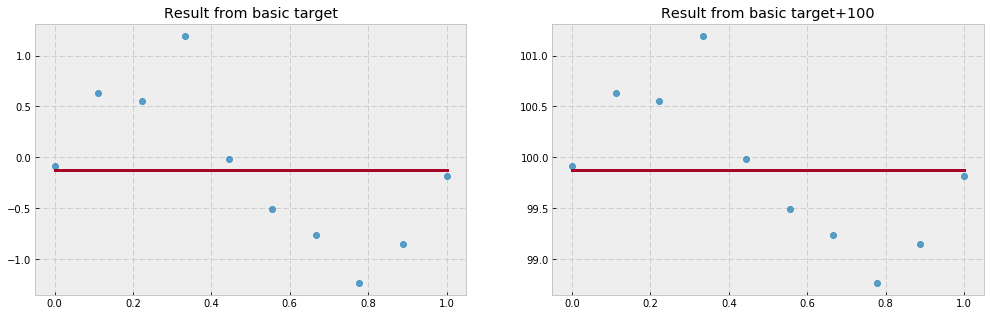

In [7]:
# 레귤러라이제이션에서 절편항을 포함시킬지 말지를 결정
reg_intercept = False

###############################################################
# 주어진 타겟에 대해 회귀를 하고
if regularizer == 'L1' :
    # L1 레귤러의 경우 수치 안정성을 위해 직접 미분한 그래디언트 함수 사용
    w = fit(x_train, t_train, grad=grad_L1, strict=False)
else :
    w = fit(x_train, t_train)
 
###############################################################
# 타겟값에 100을 더하고 다시 회귀 한다.
t_train100 = t_train+100

if regularizer == 'L1' :
    # L1 레귤러의 경우 수치 안정성을 위해 직접 미분한 그래디언트 함수 사용
    w100 = fit(x_train, t_train100,  grad=grad_L1, strict=False)
else :
    w100 = fit(x_train, t_train100)    
    
plt.rcParams["figure.figsize"] = (17,5)

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)


X = np.array([ x**i for i in range(M+1) ])  
y = (w.reshape(-1,1) * X).sum(axis=0)
y100 = (w100.reshape(-1,1) * X).sum(axis=0)

ax1.plot(x_train, t_train, 'o', alpha=0.8)
ax1.plot(x, y, lw=3)
ax1.set_title("Result from basic target")

ax2.plot(x_train, t_train100, 'o', alpha=0.8)
ax2.plot(x, y100, lw=3)
ax2.set_title("Result from basic target+100")

plt.show()    

- 두 결과를 비교하면 회귀 결과가 정확하게 같은 위치에 있음을 확인할 수 있다.

- 즉, 원 데이터의 경우 절편이 -0.12614, 데이터에 100을 더한 경우 99.874가 되어 절편은 거의 100만큼 차이가 난다.

- 수치 오차를 무시하면 정확히 100만큼 위로 시프트 된것이다.

- 이제 절편항을 레귤러라이제이션에 포함시키고 다시 반복한다.

################################################################
# START OPTIMIZATION
################################################################
DATA       : [0.     0.1111 0.2222 0.3333 0.4444 0.5556 0.6667 0.7778 0.8889 1.    ], dtype : float64
TARGET     : [-0.0834  0.6315  0.5576  1.1941 -0.0167 -0.5104 -0.7654 -1.2339 -0.8544 -0.1818], dtype : float64
INIT POINT : [0.0976 0.4304], dtype : float64
POLY. DEG. : 1
PARAMETERS : 2
METHOD     : CGM
##############
# START ITER.
##############
Iter:    0, |c|:13.0853322, Cost:4.4435031
Iter:  500, |c|:6.8973275, Cost:2.6372982
Iter: 1000, |c|:6.8973275, Cost:2.6372982
Iter: 1500, |c|:8.0324625, Cost:2.6372982
Iter: 2000, |c|:9.4749381, Cost:2.6372982
max-iter break
iter: 2499, w:[-4.5977e-17 -2.3894e-17], cost:2.6372982
################################################################
# START OPTIMIZATION
################################################################
DATA       : [0.     0.1111 0.2222 0.3333 0.4444 0.5556 0.6667 0.

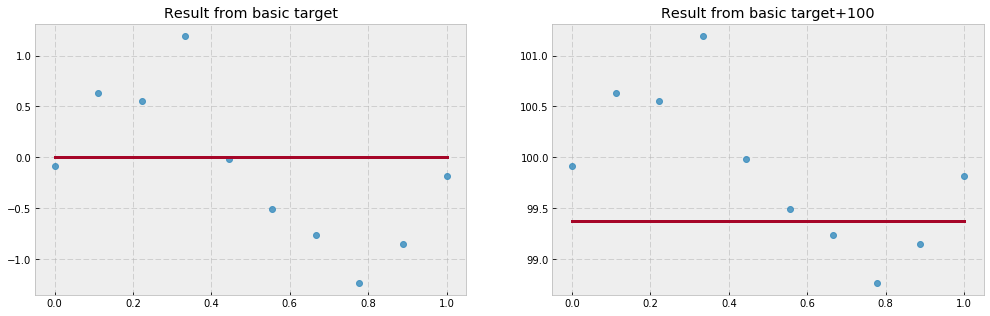

In [8]:
# 레귤러라이제이션에서 절편항을 포함시킬지 말지를 결정
reg_intercept = True

###############################################################
# 주어진 타겟에 대해 회귀를 하고
if regularizer == 'L1' :
    # L1 레귤러의 경우 수치 안정성을 위해 직접 미분한 그래디언트 함수 사용
    w = fit(x_train, t_train, grad=grad_L1, strict=False)
else :
    w = fit(x_train, t_train)
 
###############################################################
# 타겟값에 100을 더하고 다시 회귀 한다.
t_train100 = t_train+100

if regularizer == 'L1' :
    # L1 레귤러의 경우 수치 안정성을 위해 직접 미분한 그래디언트 함수 사용
    w100 = fit(x_train, t_train100,  grad=grad_L1, strict=False)
else :
    w100 = fit(x_train, t_train100)    
    
plt.rcParams["figure.figsize"] = (17,5)

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)


X = np.array([ x**i for i in range(M+1) ])  
y = (w.reshape(-1,1) * X).sum(axis=0)
y100 = (w100.reshape(-1,1) * X).sum(axis=0)

ax1.plot(x_train, t_train, 'o', alpha=0.8)
ax1.plot(x, y, lw=3)
ax1.set_title("Result from basic target")

ax2.plot(x_train, t_train100, 'o', alpha=0.8)
ax2.plot(x, y100, lw=3)
ax2.set_title("Result from basic target+100")

plt.show()    

- 결과를 보면 앞선 결과와는 다르게 두 회귀결과에 차이가 나타나는 것을 확인 할 수 있다.

- 이 경우 왼쪽 그래프를 보면 절편값이 앞선 결과에서는 -0.12614이었는데 이마저도 더 줄어들어 0이 되어 버렸다.

- 따라서 데이터에 100씩 더한 경우 절편이 100만큼 차이가 나서 100이 되어야 하지만 이 경우도 절편값에 레귤러라이제이션이 더 적용되어 앞서 99.874에서 더 줄어들어 99.374로 둘어 들었다.

- 결과적으로 절편의 차이는 100이 아니라 99.374가 된다.

In [1]:
%%html
<link href='https://fonts.googleapis.com/earlyaccess/notosanskr.css' rel='stylesheet' type='text/css'>
<!--https://github.com/kattergil/NotoSerifKR-Web/stargazers-->
<link href='https://cdn.rawgit.com/kattergil/NotoSerifKR-Web/5e08423b/stylesheet/NotoSerif-Web.css' rel='stylesheet' type='text/css'>
<!--https://github.com/Joungkyun/font-d2coding-->
<link href="http://cdn.jsdelivr.net/gh/joungkyun/font-d2coding/d2coding.css" rel="stylesheet" type="text/css">
<style>
    h1     { font-family: 'Noto Sans KR' !important; color:#348ABD !important;   }
    h2     { font-family: 'Noto Sans KR' !important; color:#467821 !important;   }
    h3, h4 { font-family: 'Noto Sans KR' !important; color:#A60628 !important;   }
    p:not(.navbar-text) { font-family: 'Noto Serif KR', 'Nanum Myeongjo'; font-size: 12pt; line-height: 200%;  text-indent: 10px; }
    li:not(.dropdown):not(.p-TabBar-tab):not(.p-MenuBar-item):not(.jp-DirListing-item):not(.p-CommandPalette-header):not(.p-CommandPalette-item):not(.jp-RunningSessions-item)
            { font-family: 'Noto Serif KR', 'Nanum Myeongjo'; font-size: 12pt; line-height: 200%; }
    table  { font-family: 'Noto Sans KR' !important;  font-size: 11pt !important; }           
    li > p  { text-indent: 0px; }
    li > ul { margin-top: 0px !important; }       
    sup { font-family: 'Noto Sans KR'; font-size: 9pt; } 
    code, pre  { font-family: D2Coding, 'D2 coding' !important; font-size: 12pt !important; line-height: 130% !important;}
    .code-body { font-family: D2Coding, 'D2 coding' !important; font-size: 12pt !important;}
    .ns        { font-family: 'Noto Sans KR'; font-size: 15pt;}
    .summary   {
                   font-family: 'Georgia'; font-size: 12pt; line-height: 200%; 
                   border-left:3px solid #FF0000; 
                   padding-left:20px; 
                   margin-top:10px;
                   margin-left:15px;
               }
    .green { color:#467821 !important; }
    .comment { font-family: 'Noto Sans KR'; font-size: 10pt; }
</style>